In [1]:
import numpy as np
import music21
from music21 import converter
from music21 import stream
from music21.note import Note
from copy import deepcopy

In [2]:
def mark_liquescents(notes, indices):
    for i, note in enumerate(notes):
        if i in indices:
            note.editorial['liquescent'] = True
            note.notehead = 'x'

In [3]:
def is_liquescent(note):
    return note.editorial.get('liquescent', False)

In [4]:
def repeat_stream(s, num_repeats):
    s2 = deepcopy(s)
    for _ in range(num_repeats - 1):
        for el in s:
            s2.append(deepcopy(el))
    return s2

In [5]:
def slur_final_notes(measure):
    n1 = measure[-2]
    n2 = measure[-1]
    slur = music21.spanner.Slur([n1, n2])
    measure.insert(0, slur)

In [6]:
def append_mirror(mylist):
    return mylist + mylist[::-1]

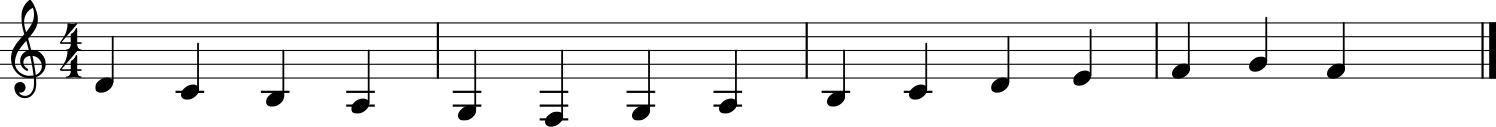

In [139]:
A_scale = converter.parse("tinynotation: d c B A G F G A B c d e f g f").flat.notes
B_scale = converter.parse("tinynotation: F G A B c d c B A G F E D C D").flat.notes
A_scale.show()

In [140]:
notes_A = repeat_stream(A_scale, 16)
notes_A.insertAndShift(0, music21.note.Note('E4'))

notes_B = repeat_stream(B_scale, 16)
notes_B.insertAndShift(0, music21.note.Note('E3'))

In [31]:
def init_score(measure_lengths, measure_divisi):
    score = stream.Score()
    part_S = stream.Part(id='soprano')
    part_A = stream.Part(id='alto')
    part_T = stream.Part(id='tenor')
    part_B = stream.Part(id='bass')
    parts = [part_S, part_A, part_T, part_B]
    score.append(parts)
    
    score.editorial['measures'] = len(measure_lengths)
    score.editorial['measure_lengths'] = measure_lengths
    score.editorial['measure_divisi'] = measure_divisi

    # Insert measures
    for length, divisi in zip(measure_lengths, measure_divisi):
        for part in parts:
            measure = stream.Measure()
            measure.editorial['length'] = length
            measure.editorial['divisi'] = divisi
            letter = part.id[0].upper()
            measure.editorial['active'] = letter in divisi
            part.append(measure)

    # Set clefs
    bass_clef = music21.clef.BassClef()
    part_B.measure(1).append(bass_clef)
    tenor_clef = music21.clef.Treble8vbClef()
    part_T.measure(1).append(tenor_clef)
    return score

measure_lengths = append_mirror([7, 9, 7]) * 2
measure_divisi = append_mirror(['SA', 'SATB', 'TB']) * 2
score = init_score(measure_lengths, measure_divisi)

In [33]:
def fill_measures(score, notes_A, notes_B):
    alto = score.getElementById('alto')
    bass = score.getElementById('bass')
    notes_A = deepcopy(notes_A)
    notes_B = deepcopy(notes_B)
    
    pos_A = 0
    pos_B = 0
    for m, (length, divisi) in enumerate(
        zip(score.editorial['measure_lengths'], score.editorial['measure_divisi'])):
        if 'A' in divisi:
            notes = notes_A[pos_A:pos_A+length]
            if m % 6 == 0:
                notes[0].pitch.nameWithOctave = 'E4'

            if m % 6 == 4:
                notes[0].pitch.nameWithOctave = 'E4'

            alto.measure(m+1).append(notes)
            pos_A += length

        if 'B' in divisi:
            notes = notes_B[pos_B:pos_B+length]
            if m % 6 == 1:
                notes[0].pitch.nameWithOctave = 'E3'

            if m % 6 == 3:
                notes[0].pitch.nameWithOctave = 'E3'

            bass.measure(m+1).append(notes)
            pos_B += length
            
fill_measures(score, notes_A, notes_B)

In [34]:
def insert_ornaments(part, ornaments):
    for note, ornament in zip(part.recurse(classFilter='Note'), ornaments):
        measure = note.getContextByClass('Measure')
        if ornament is not None:
            ornament = deepcopy(ornament)
            ornament.notehead = 'diamond'
            ornament.editorial['ornament'] = True
            measure.insertAndShift(note.offset + 1, ornament)
            slur = music21.spanner.Slur([note, ornament])
            measure.insert(0, slur)

In [35]:
def extend_note(note, amount=1):
    assert isinstance(note, Note)
    measure = note.getContextByClass('Measure')
    measure.shiftElements(amount, startOffset=note.offset + 1)
    note.quarterLength += amount

In [36]:
def extend_unornamented_notes_in_measure(measureA, measureB):
    posA = 0
    posB = 0
    while posA < len(measureA.notes) - 2 or posB < len(measureB.notes) - 2:
        next_A = measureA.notes[posA + 1]
        next_B = measureB.notes[posB + 1]
        nextA_is_ornament = next_A.editorial.get('ornament', False)
        nextB_is_ornament = next_B.editorial.get('ornament', False)

        if nextA_is_ornament and not nextB_is_ornament:
            extend_note(measureB.notes[posB])
            posA += 1

        if not nextA_is_ornament and nextB_is_ornament:
            extend_note(measureA.notes[posA])
            posB += 1

        else:
            posA += 1 
            posB += 1
            
def extend_unornamented_notes(score):
    alto = score.getElementById('alto')
    bass = score.getElementById('bass')
    for m, divisi in enumerate(score.editorial['measure_divisi']):
        if divisi != 'SATB': continue
        measureA = alto.measure(m + 1)
        measureB = bass.measure(m + 1)
        extend_unornamented_notes_in_measure(measureA, measureB)

In [37]:
def set_time_signatures(score):
    for m in range(score.editorial['measures']):
        bar_duration = int(score.measure(m+1).quarterLength)
        t = music21.meter.TimeSignature(f'{bar_duration}/4')
        t.style.hideObjectOnPrint = True
        for part in score.parts:
            part.measure(m+1).timeSignature = t

In [38]:
ornaments_A = [
    None,
    None, 'G3', None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None,
    'B3', None, None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None,
    None, 'G3', None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None,
    'E4', None, 'G3', None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None,
]
ornaments_A = [None if n is None else Note(n) for n in ornaments_A]

In [39]:
ornaments_B = [
    None,
    None, 'E3', None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, 'B2',
    None, 'E3', None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, 'B2',
    None, 'E3', None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, 'B2',
    None, 'E3', None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, 'B2',
]
ornaments_B = [None if n is None else Note(n) for n in ornaments_B]

In [40]:
measure_lengths = append_mirror([7, 9, 7]) * 2
measure_divisi = append_mirror(['SA', 'SATB', 'TB']) * 2
score = init_score(measure_lengths, measure_divisi)
fill_measures(score, notes_A, notes_B)

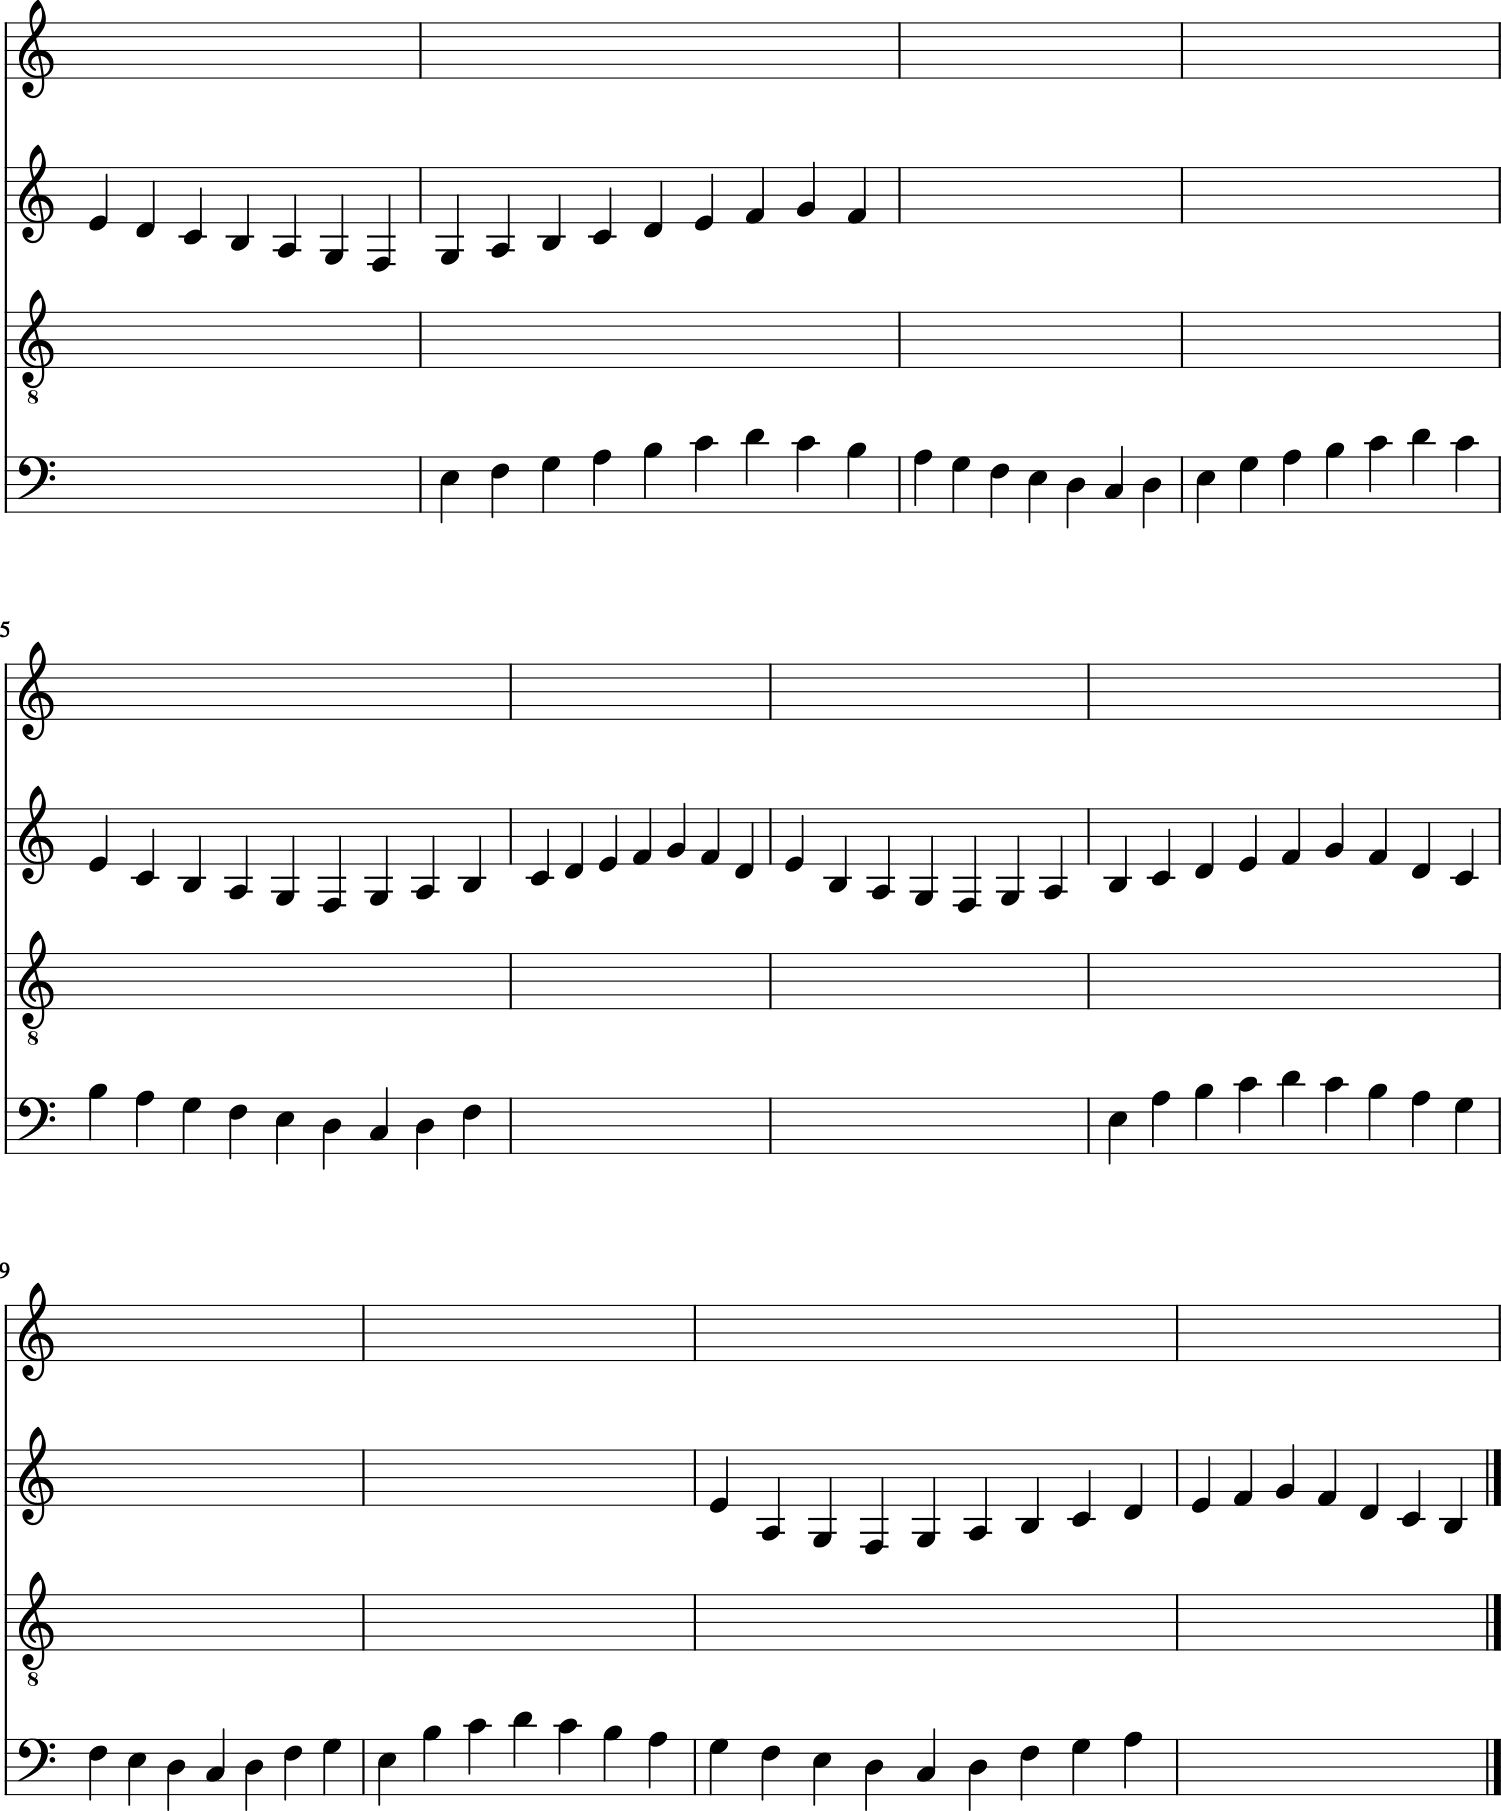

In [41]:
score.show()

In [42]:
measure_lengths = append_mirror([7, 9, 7]) * 2
measure_divisi = append_mirror(['SA', 'SATB', 'TB']) * 2
score = init_score(measure_lengths, measure_divisi)
fill_measures(score, notes_A, notes_B)
insert_ornaments(score.getElementById('alto'), ornaments_A)
insert_ornaments(score.getElementById('bass'), ornaments_B)
extend_unornamented_notes(score)
set_time_signatures(score)

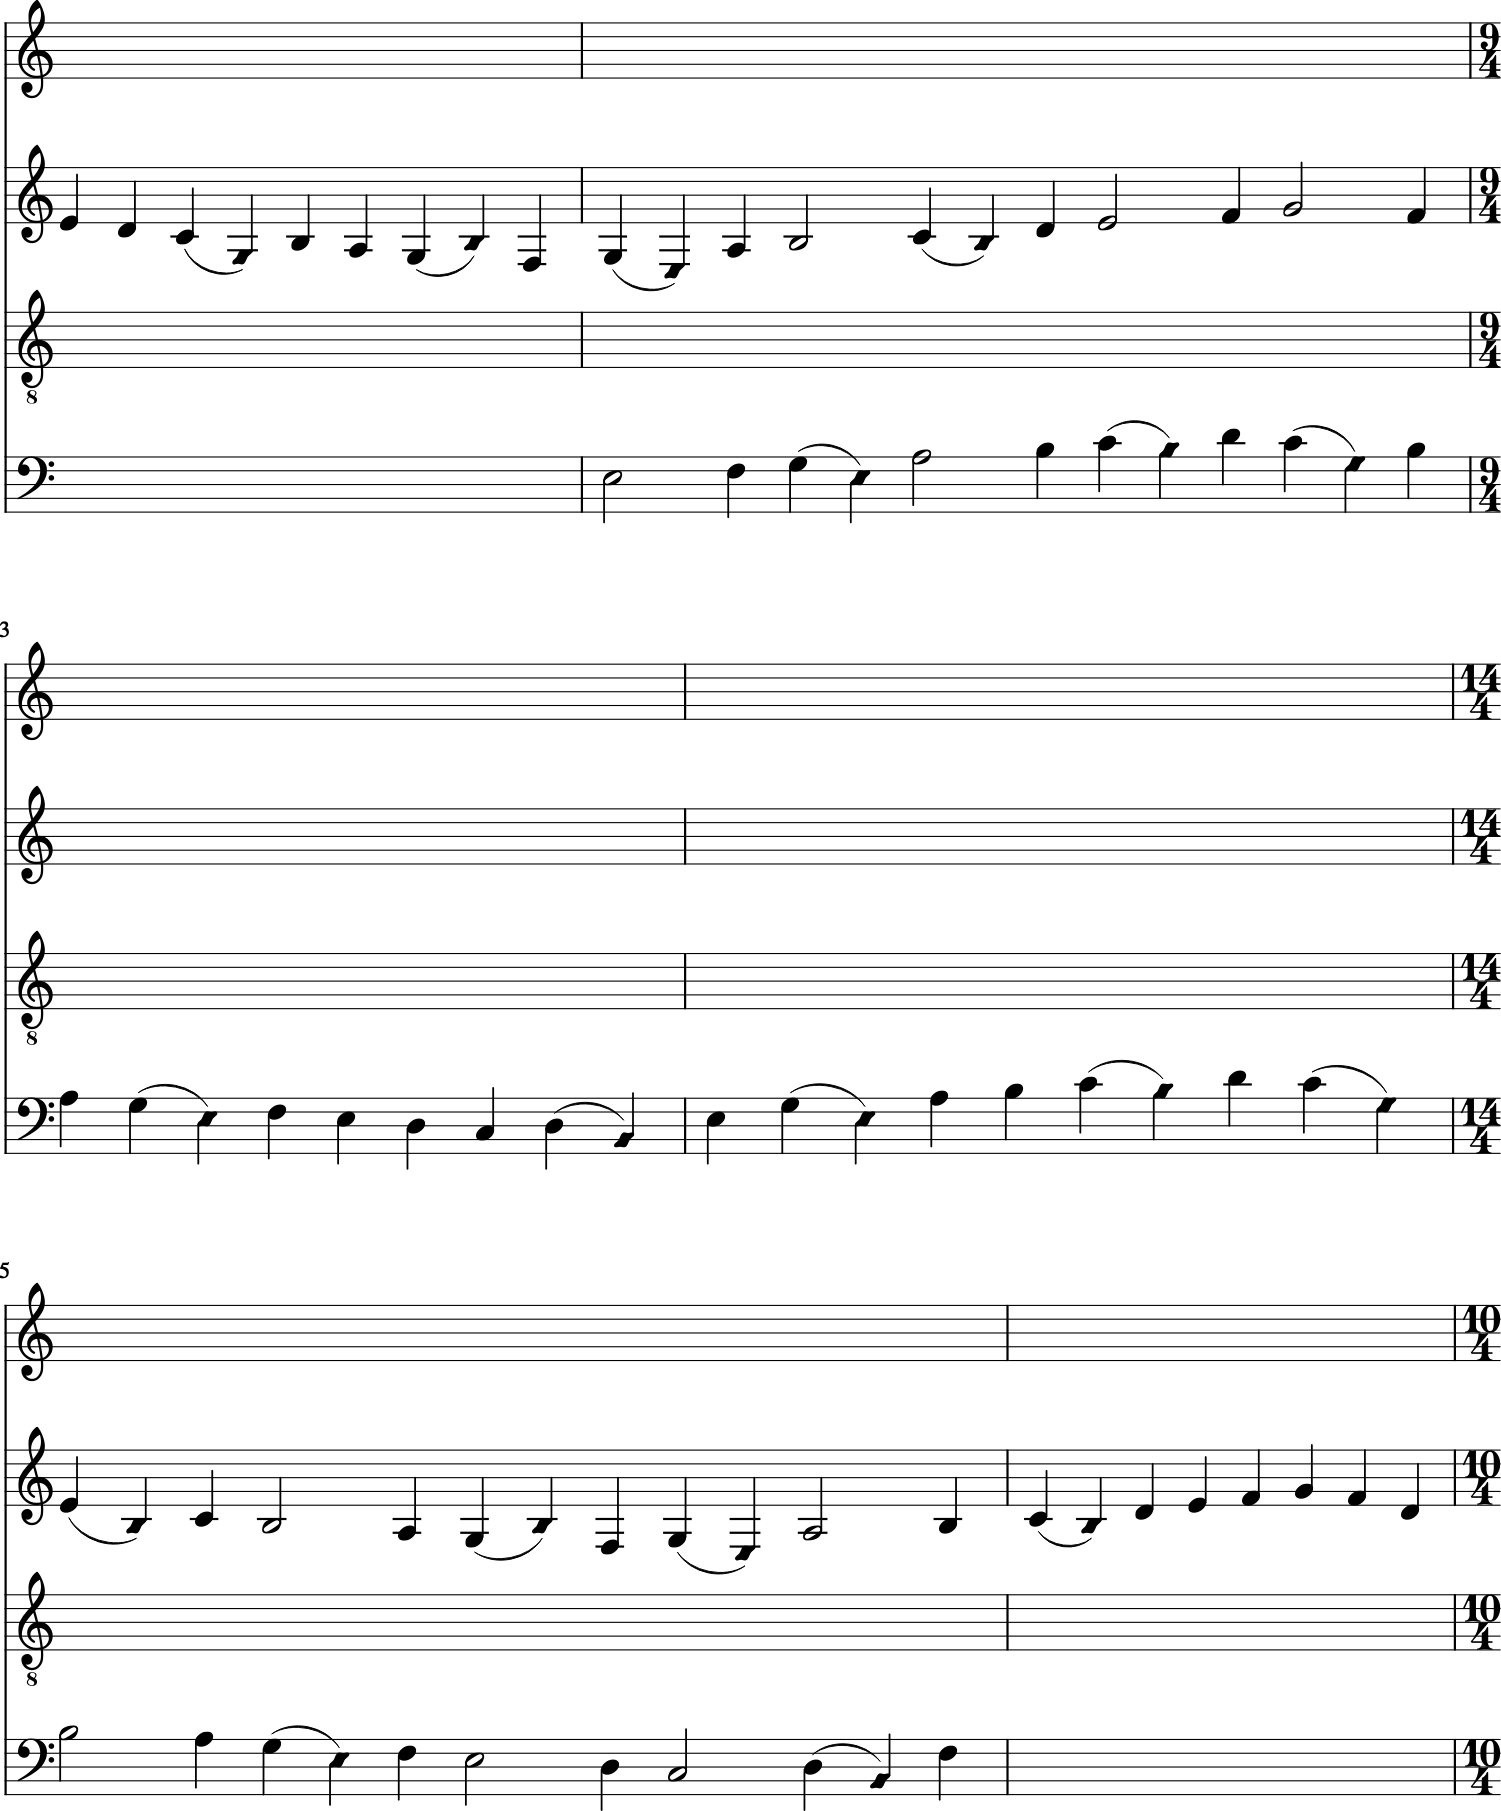

In [43]:
score.show()

### To do

* Rename ornaments to melismas
* Add tintanibuli voices

### Tenor part

In [44]:
tenor_pitches = ['E3', 'G3', 'B3', 'E4', 'G4']
tenor_pitches = [Note(n) for n in tenor_pitches]

In [45]:
def tintanibulli_above(note, steps = 1):
    i = 0
    for p in tenor_pitches:
        if note < p:
            i += 1
            if i == steps:
                return deepcopy(p)
    return None

def tintanibulli_below(note, steps = 1):
    i = 0
    for p in tenor_pitches[::-1]:
        if p < note:
            i += 1
            if i == steps:
                return deepcopy(p)
    return None

tintanibulli_below(Note('E3'))

In [46]:
notes_T = stream.Stream()
prev = Note('E3')
for n1, n2 in zip(notes_B[:30], notes_B[1:31]):
    if n1 < n2:
        # Ascending
        next_note = tintanibulli_above(prev)
        if next_note is None or next_note == n2:
            next_note = tintanibulli_below(prev)
        
    elif n1 > n2:
        next_note = tintanibulli_below(prev)
        if next_note is None or next_note == n2:
            next_note = tintanibulli_above(prev)
            
    notes_T.append(next_note)
    prev = next_note
    
notes_T.insertAndShift(0, Note('B3'))

In [48]:
measure_lengths = append_mirror([7, 9, 7]) * 2
measure_divisi = append_mirror(['SA', 'SATB', 'TB']) * 2
score = init_score(measure_lengths, measure_divisi)
fill_measures(score, notes_A, notes_B)
insert_ornaments(score.getElementById('alto'), ornaments_A)
insert_ornaments(score.getElementById('bass'), ornaments_B)
extend_unornamented_notes(score)
set_time_signatures(score)

In [51]:
tenor = score.getElementById('tenor')
bass = score.getElementById('bass')

In [63]:
for m in range(1,2):
    measureT = tenor.measure(m+1)
    measureB = bass.measure(m+1)
    for note in measureB.notes:
        print(note)

<music21.note.Note E>
<music21.note.Note F>
<music21.note.Note G>
<music21.note.Note E>
<music21.note.Note A>
<music21.note.Note B>
<music21.note.Note C>
<music21.note.Note B>
<music21.note.Note D>
<music21.note.Note C>
<music21.note.Note G>
<music21.note.Note B>


In [133]:
score = init_score(measure_lengths, measure_divisi)
tenor = score.getElementById('tenor')
bass = score.getElementById('bass')

In [134]:

class Syllable(music21.stream.Stream):
    def __init__(self, *args, index=None, text=''):
        self.text_ = text
        self.index_ = index
        super().__init__(*args)
    
    def setDuration(self, quarterLength):
        note_duration = quarterLength / len(self.notes)
        for note in self.notes:
            note.quarterLength = note_duration
        
bass_notes = ['E3', 'F3', 'G3', 'A3']
for index, n in enumerate(bass_notes):
    bass.measure(1).append(Syllable([Note(n, index=index)]))
    
s1 = bass.measure(1)[0]
s1.setDuration(2)

s3 = bass.measure(1)[3]
s3.append(Note('E3'))
s3.setDuration(1)

# syll = Syllable(['E4'])
# tenor.measure(1).insert(syll)

In [138]:
notes_B.show('text')

{0.0} <music21.note.Note E>
{1.0} <music21.note.Note F>
{2.0} <music21.note.Note G>
{3.0} <music21.note.Note A>
{4.0} <music21.note.Note B>
{5.0} <music21.note.Note C>
{6.0} <music21.note.Note D>
{7.0} <music21.note.Note C>
{8.0} <music21.note.Note B>
{9.0} <music21.note.Note A>
{10.0} <music21.note.Note G>
{11.0} <music21.note.Note F>
{12.0} <music21.note.Note E>
{13.0} <music21.note.Note D>
{14.0} <music21.note.Note C>
{15.0} <music21.note.Note D>
{16.0} <music21.note.Note F>
{17.0} <music21.note.Note G>
{18.0} <music21.note.Note A>
{19.0} <music21.note.Note B>
{20.0} <music21.note.Note C>
{21.0} <music21.note.Note D>
{22.0} <music21.note.Note C>
{23.0} <music21.note.Note B>
{24.0} <music21.note.Note A>
{25.0} <music21.note.Note G>
{26.0} <music21.note.Note F>
{27.0} <music21.note.Note E>
{28.0} <music21.note.Note D>
{29.0} <music21.note.Note C>
{30.0} <music21.note.Note D>
{31.0} <music21.note.Note F>
{32.0} <music21.note.Note G>
{33.0} <music21.note.Note A>
{34.0} <music21.note.Not

In [126]:
len(s.notes)

1

In [121]:
s.quarterLength

1.0

In [113]:
bass.measure(1).flat.show('text')

{0.0} <music21.clef.BassClef>
{0.0} <music21.note.Note E>
{1.0} <music21.note.Note F>
{2.0} <music21.note.Note G>
{3.0} <music21.note.Note A>


In [73]:
music21.stream.Stream([Note('E4')])

<music21.stream.Stream 0x11ceb1250>

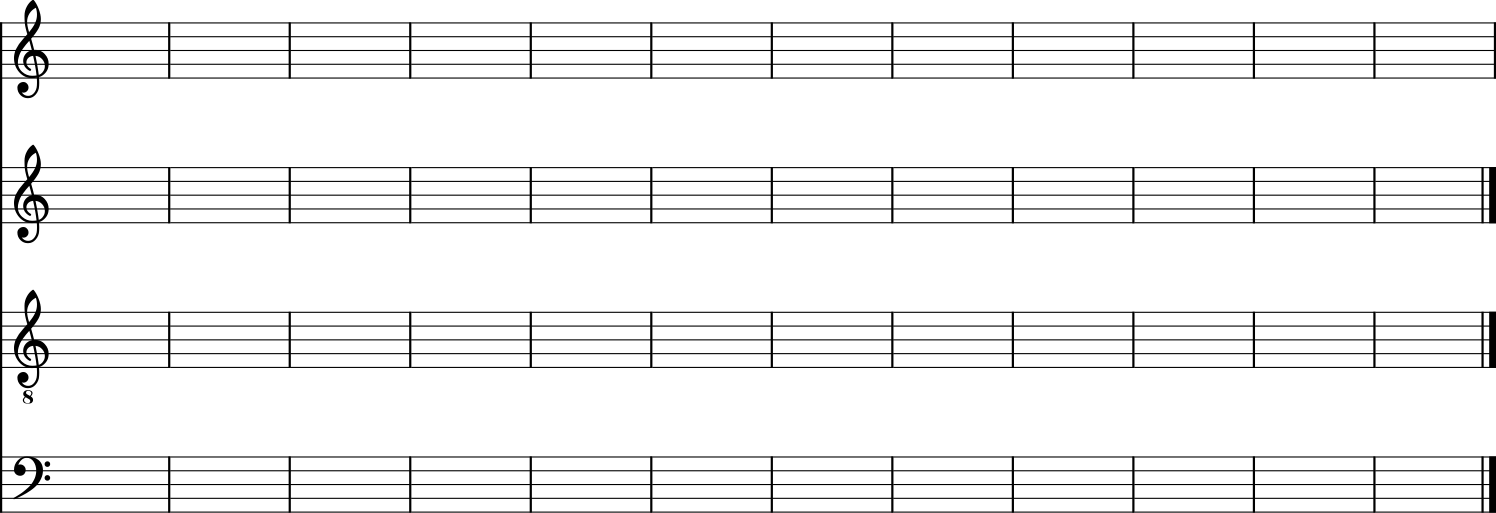

In [67]:
score.show()

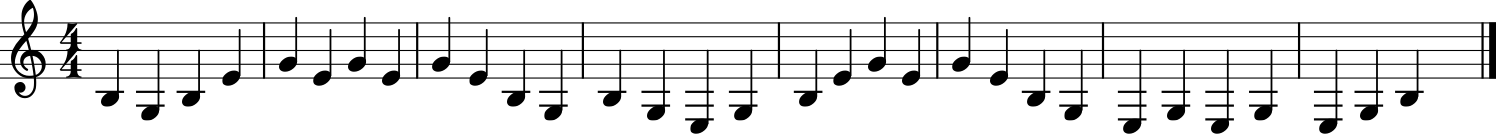

In [30]:
notes_T.show()

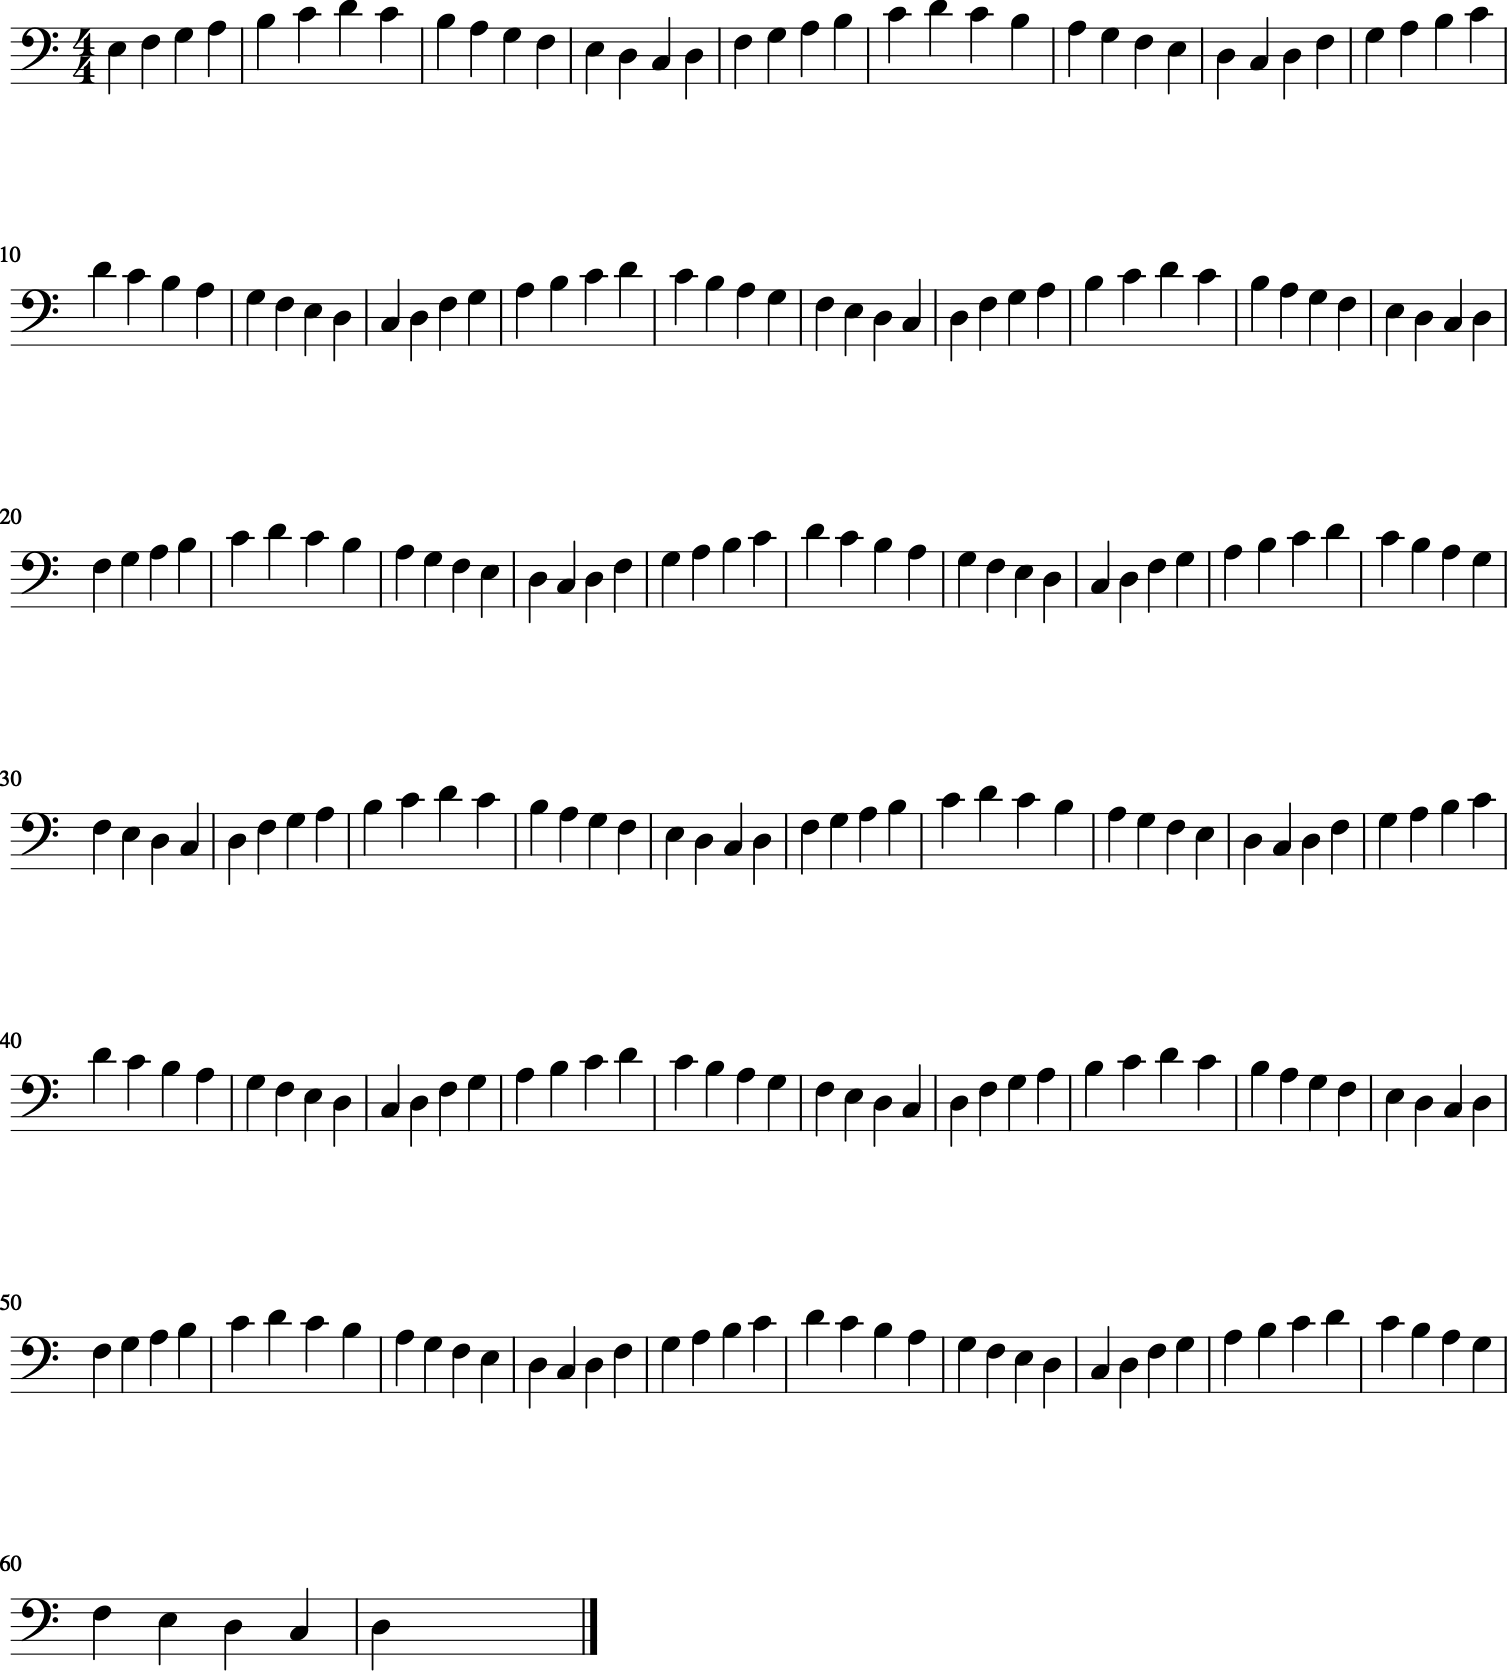

In [26]:
notes_B.show()

## Old

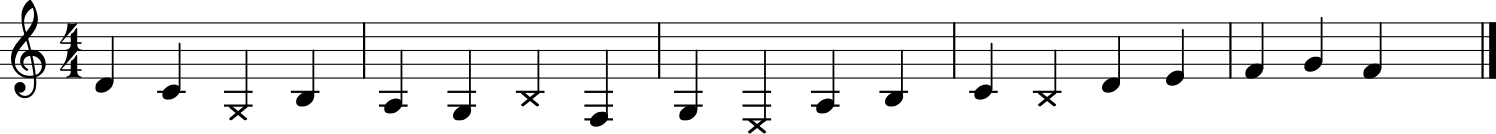

In [240]:
A_pattern = converter.parse("tinynotation: d c G B A G B F G E A B c B d e f g f")
A_pattern = stream.Stream(A_pattern.flat.notes)
mark_liquescents(A_pattern, liquescents)
A_pattern.show()

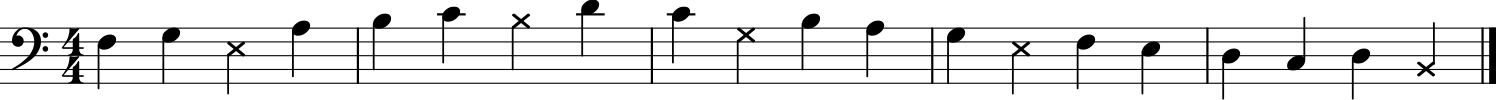

In [241]:
B_pattern = converter.parse("tinynotation: F G E A B c B d c G B A G E F E D C D BB")
B_pattern = stream.Stream(B_pattern.flat.notes)
mark_liquescents(B_pattern, liquescents)
B_pattern.show()

In [242]:
A_pattern = repeat_stream(A_pattern, 16)
B_pattern = repeat_stream(B_pattern, 16)

A_pattern.insertAndShift(0, music21.note.Note('E4'))
B_pattern.insertAndShift(0, music21.note.Note('E3'))

In [367]:
score = stream.Score()
A = stream.Part(id='alto')
B = stream.Part(id='bass')
parts = [A, B]
score.append(parts)

In [368]:
alto_notes_per_measure = append_mirror([7, 9, 7])[:3]
divisi_per_measure = append_mirror(['SA', 'SATB', 'TB'])[:3]

In [ ]:
# To do: rewrite using this: first extract the number of required notes

In [376]:
def extract_notes(pattern, start, num_notes):
    end = start
    count = 0
    while count < num_notes:
        end += 1
        if not is_liquescent(pattern[end]):
            count += 1
    return pattern[start:end]

extract_notes(A_pattern, 0, 7)

[<music21.note.Note E>,
 <music21.note.Note D>,
 <music21.note.Note C>,
 <music21.note.Note G>,
 <music21.note.Note B>,
 <music21.note.Note A>,
 <music21.note.Note G>,
 <music21.note.Note B>,
 <music21.note.Note F>]

In [ ]:
def fill_single_part_measure(measure, pattern, pos, num_notes):
    while note_count < num_notes:
        

In [370]:
A_pos = 0
B_pos = 0

for num_notes, divisi in zip(alto_notes_per_measure, divisi_per_measure):
    A_measure = stream.Measure()
    B_measure = stream.Measure()
    has_A = 'A' in divisi
    has_B = 'B' in divisi
    
    bar_duration = 0
    note_count = 0
    while note_count < num_notes:
        A_note = A_pattern[A_pos]
        B_note = B_pattern[B_pos]
        
        if has_A and not has_B:
            A_pos += 1
            A_measure.append(deepcopy(A_note))
            if is_liquescent(A_note): 
                slur_final_notes(A_measure)
            else: 
                note_count += 1
            
            # Final liquescent at the end of a bar
            if note_count == num_notes and is_liquescent(A_pattern[A_pos+1]):
                A_pos += 1
                A_measure.append(deepcopy(A_pattern[A_pos+1]))
                slur_final_notes(A_measure)
            
        if not has_A and has_B:
            B_pos += 1
            B_measure.append(deepcopy(B_note))
            if is_liquescent(B_note): 
                slur_final_notes(B_measure)
            else:
                note_count += 1
            
            # Final liquescent
            if note_count == num_notes and is_liquescent(B_pattern[B_pos+1]):
                B_pos += 1
                B_measure.append(deepcopy(B_pattern[B_pos+1]))
                slur_final_notes(B_measure)
        
        elif has_A and has_B:            
            if is_liquescent(A_note) and not is_liquescent(B_note):
                A_measure.append(deepcopy(A_note))
                A_pos += 1
                B_measure[-1].quarterLength = 2
                slur_final_notes(A_measure)

            elif not is_liquescent(A_note) and is_liquescent(B_note):
                A_measure[-1].quarterLength = 2
                B_measure.append(deepcopy(B_note))
                B_pos += 1
                slur_final_notes(B_measure)

            else:
                A_measure.append(deepcopy(A_note))
                A_pos += 1
                
                B_measure.append(deepcopy(B_note))
                B_pos += 1
                
                if is_liquescent(A_note): slur_final_notes(A_measure)
                if is_liquescent(B_note): slur_final_notes(B_measure)
                if not is_liquescent(A_note): note_count += 1
                
            if note_count == num_notes and is_liquescent(A_pattern[A_pos+1]):
                pass
                # to do 
        
        bar_duration += 1

    A_measure.timeSignature = music21.meter.TimeSignature(f'{bar_duration}/4')
    B_measure.timeSignature = music21.meter.TimeSignature(f'{bar_duration}/4')
    A.append(A_measure)
    B.append(B_measure)

IndexError: attempting to access index -1 while elements is of size 0